# 时序预测练习--AI电力能耗预测大赛

案例数据来源于江苏镇江扬中市的高新区企业历史近2年的用电量，希望能够根据历史数据去精准预测未来一个月每一天的用电量，这是一个很典型的时序数据回归类问题，我们来看看如何用数据驱动的建模方法去完成这样一个预测。

**竞赛数据**

本次竞赛主要数据源为企业用电量表Tianchi_power2，我们抽取了扬中市高新区的1000多家企业的用电量（数据进行了脱敏），包括企业ID（匿名化处理），日期和用电量。具体字段如下表：

tianchi_power2

| 列名              | 类型   | 含义   | 示例     |
| ----------------- | ------ | ------ | -------- |
| record_date       | string | 日期   | 20150101 |
| user_id           | bigint | 企业id | 1        |
| power_consumption | bigint | 用电量 | 1031     |
| ...               | ...    | ...    | ...      |

赛题还有天气数据，本案例着重练习，不使用这个数据。

**选手提交结果表**

tianchi_power_answer

| 列名              | 类型   | 含义         | 示例     |
| ----------------- | ------ | ------------ | -------- |
| predict_date      | string | 日期         | 2016/9/1 |
| power_consumption | bigint | 预测的用电量 | 1031     |


![](https://work.alibaba-inc.com/aliwork_tfs/g01_alibaba-inc_com/tfscom/TB1oAMfQFXXXXX1XVXXXXXXXXXX.tfsprivate.jpg)

## 载入数据

In [25]:
import numpy as np
import pandas as pd
%matplotlib inline

In [5]:
data_1 = pd.read_csv('../../data/ai_power/zhenjiang_power.csv')

In [8]:
data_1.head()

,user_id,record_date,power_consumption
0,1,2015-01-01,1135.0
1,1,2015-01-02,570.0
2,1,2015-01-03,3418.0
3,1,2015-01-04,3968.0
4,1,2015-01-05,3986.0


In [15]:
sorted(data_1['record_date'].unique())

['2015-01-01',
 '2015-01-02',
 '2015-01-03',
 '2015-01-04',
 '2015-01-05',
 '2015-01-06',
 '2015-01-07',
 '2015-01-08',
 '2015-01-09',
 '2015-01-10',
 '2015-01-11',
 '2015-01-12',
 '2015-01-13',
 '2015-01-14',
 '2015-01-15',
 '2015-01-16',
 '2015-01-17',
 '2015-01-18',
 '2015-01-19',
 '2015-01-20',
 '2015-01-21',
 '2015-01-22',
 '2015-01-23',
 '2015-01-24',
 '2015-01-25',
 '2015-01-26',
 '2015-01-27',
 '2015-01-28',
 '2015-01-29',
 '2015-01-30',
 '2015-01-31',
 '2015-02-01',
 '2015-02-02',
 '2015-02-03',
 '2015-02-04',
 '2015-02-05',
 '2015-02-06',
 '2015-02-07',
 '2015-02-08',
 '2015-02-09',
 '2015-02-10',
 '2015-02-11',
 '2015-02-12',
 '2015-02-13',
 '2015-02-14',
 '2015-02-15',
 '2015-02-16',
 '2015-02-17',
 '2015-02-18',
 '2015-02-19',
 '2015-02-20',
 '2015-02-21',
 '2015-02-22',
 '2015-02-23',
 '2015-02-24',
 '2015-02-25',
 '2015-02-26',
 '2015-02-27',
 '2015-02-28',
 '2015-03-01',
 '2015-03-02',
 '2015-03-03',
 '2015-03-04',
 '2015-03-05',
 '2015-03-06',
 '2015-03-07',
 '2015-03-

In [9]:
data_1.describe()

,user_id,power_consumption
count,885486.000000,8.854860e+05
mean,727.500000,2.619980e+03
std,419.733783,3.154743e+04
min,1.000000,1.000000e+00
25%,364.000000,4.200000e+01
50%,727.500000,2.610000e+02
75%,1091.000000,8.250000e+02
max,1454.000000,1.310016e+06


In [10]:
data_2 = pd.read_csv('../../data/ai_power/zhenjiang_power_9.csv')

In [11]:
data_2.head()

,record_date,user_id,power_consumption
0,2016/9/2,20,1
1,2016/9/3,20,1
2,2016/9/4,20,1
3,2016/9/1,49,1
4,2016/9/2,49,1


可以看到数据集1和2的时间格式不一致

In [16]:
sorted(data_2['record_date'].unique())

['2016/9/1',
 '2016/9/10',
 '2016/9/11',
 '2016/9/12',
 '2016/9/13',
 '2016/9/14',
 '2016/9/15',
 '2016/9/16',
 '2016/9/17',
 '2016/9/18',
 '2016/9/19',
 '2016/9/2',
 '2016/9/20',
 '2016/9/21',
 '2016/9/22',
 '2016/9/23',
 '2016/9/24',
 '2016/9/25',
 '2016/9/26',
 '2016/9/27',
 '2016/9/28',
 '2016/9/29',
 '2016/9/3',
 '2016/9/30',
 '2016/9/4',
 '2016/9/5',
 '2016/9/6',
 '2016/9/7',
 '2016/9/8',
 '2016/9/9']

In [18]:
# 合并两个数据集
train_df = pd.concat([data_1, data_2])

D:\APP\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [19]:
data_1.shape

(885486, 3)

In [20]:
data_2.shape

(43620, 3)

In [21]:
train_df.shape

(929106, 3)

In [22]:
929106 == 43620 + 885486

True

In [23]:
# 查看训练数据
train_df.head()

,power_consumption,record_date,user_id
0,1135.0,2015-01-01,1
1,570.0,2015-01-02,1
2,3418.0,2015-01-03,1
3,3968.0,2015-01-04,1
4,3986.0,2015-01-05,1


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null object
user_id              929106 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 28.4+ MB


## 数据 EDA

通过数据透视、统计、可视化来探索数据规律

In [26]:
# 转换时间字段
train_df.loc[:, 'record_date'] = pd.to_datetime(train_df['record_date'])

In [27]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929106 entries, 0 to 43619
Data columns (total 3 columns):
power_consumption    929106 non-null float64
record_date          929106 non-null datetime64[ns]
user_id              929106 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 28.4 MB


In [28]:
len(train_df['user_id'].unique())

1454

目标：预测未来一个月每一天整个高新区的用电量。
所以无需精确到每个企业的用电量，我们简单对数据进行聚合尝试。

In [31]:
help(train_df.groupby)

Help on method groupby in module pandas.core.generic:

groupby(by=None, axis=0, level=None, as_index=True, sort=True, group_keys=True, squeeze=False, observed=False, **kwargs) method of pandas.core.frame.DataFrame instance
    Group series using mapper (dict or key function, apply given function
    to group, return result as series) or by a series of columns.
    
    Parameters
    ----------
    by : mapping, function, label, or list of labels
        Used to determine the groups for the groupby.
        If ``by`` is a function, it's called on each value of the object's
        index. If a dict or Series is passed, the Series or dict VALUES
        will be used to determine the groups (the Series' values are first
        aligned; see ``.align()`` method). If an ndarray is passed, the
        values are used as-is determine the groups. A label or list of
        labels may be passed to group by the columns in ``self``. Notice
        that a tuple is interpreted a (single) key.
    a

In [33]:
train_df = train_df[['record_date', 'power_consumption']].groupby('record_date',as_index=False).agg('sum')

In [34]:
train_df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


### 可视化

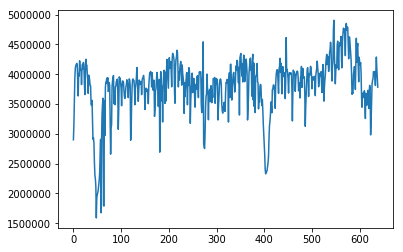

In [36]:
train_df['power_consumption'].plot()

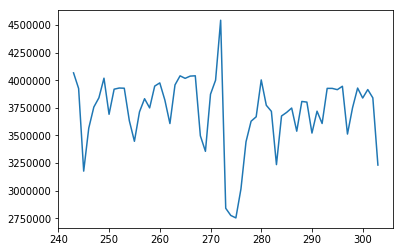

In [38]:
train_df[(train_df['record_date'] >= '2015-09-01') & (train_df['record_date']<='2015-10-31')]['power_consumption'].plot()

In [40]:
help(pd.DataFrame.set_index)

Help on function set_index in module pandas.core.frame:

set_index(self, keys, drop=True, append=False, inplace=False, verify_integrity=False)
    Set the DataFrame index (row labels) using one or more existing
    columns. By default yields a new object.
    
    Parameters
    ----------
    keys : column label or list of column labels / arrays
    drop : boolean, default True
        Delete columns to be used as the new index
    append : boolean, default False
        Whether to append columns to existing index
    inplace : boolean, default False
        Modify the DataFrame in place (do not create a new object)
    verify_integrity : boolean, default False
        Check the new index for duplicates. Otherwise defer the check until
        necessary. Setting to False will improve the performance of this
        method
    
    Examples
    --------
    >>> df = pd.DataFrame({'month': [1, 4, 7, 10],
    ...                    'year': [2012, 2014, 2013, 2014],
    ...               

In [44]:
# 将日期作为横坐标
tmp_df = train_df[(train_df['record_date'] >= '2015-09-01') & (train_df['record_date']<='2015-10-31')].copy()
tmp_df = tmp_df.set_index('record_date')

In [45]:
tmp_df.head()

,power_consumption
record_date,
2015-09-01,4066668.0
2015-09-02,3925296.0
2015-09-03,3177593.0
2015-09-04,3566662.0
2015-09-05,3757287.0


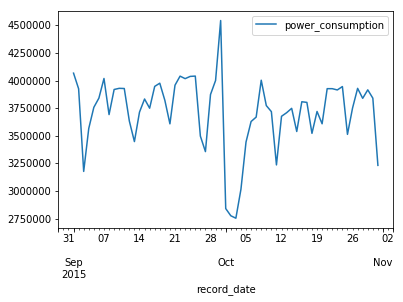

In [46]:
tmp_df.plot()

可以看到在十一假期左右用电量变低

## 添加测试数据，并拼接

In [47]:
train_df.tail()

,record_date,power_consumption
634,2016-09-26,4042132.0
635,2016-09-27,4287965.0
636,2016-09-28,4086998.0
637,2016-09-29,3941842.0
638,2016-09-30,3783264.0


In [65]:
test_df = pd.date_range('2016-10-01', periods=31, freq='D')

In [66]:
test_df = pd.DataFrame(test_df)

In [67]:
test_df.head()

,0
0,2016-10-01
1,2016-10-02
2,2016-10-03
3,2016-10-04
4,2016-10-05


In [68]:
test_df.columns = ['record_date']

In [69]:
test_df.loc[:, 'power_consumption'] = 0

In [70]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,0
1,2016-10-02,0
2,2016-10-03,0
3,2016-10-04,0
4,2016-10-05,0


In [71]:
train_df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


In [72]:
total_df = pd.concat([train_df, test_df], axis=0)

In [73]:
total_df.tail()

,record_date,power_consumption
26,2016-10-27,0.0
27,2016-10-28,0.0
28,2016-10-29,0.0
29,2016-10-30,0.0
30,2016-10-31,0.0


## 特征工程

思考企业用电量可能会和哪些因素有关系。
- 星期几
- 一个月当中的第几天（月初还是月末）
- 一年当中的第几天（季节信息）
- 一年当中的第几个月（季节）、哪一年

In [74]:
tmp = total_df['record_date']

In [76]:
total_df.loc[:, 'dow'] = total_df['record_date'].apply(lambda x:x.dayofweek)
total_df.loc[:, 'dom'] = total_df['record_date'].apply(lambda x:x.day)
total_df.loc[:, 'month'] = total_df['record_date'].apply(lambda x:x.month)
total_df.loc[:, 'year'] = total_df['record_date'].apply(lambda x:x.year)

In [77]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year
0,2015-01-01,2900575.0,3,1,1,2015
1,2015-01-02,3158211.0,4,2,1,2015
2,2015-01-03,3596487.0,5,3,1,2015
3,2015-01-04,3939672.0,6,4,1,2015
4,2015-01-05,4101790.0,0,5,1,2015


### 周末特征

In [78]:
total_df.loc[:, 'weekend'] = 0
total_df.loc[:, 'weekend_sat'] = 0
total_df.loc[:, 'weekend_sun'] = 0

In [79]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0
2,2015-01-03,3596487.0,5,3,1,2015,0,0,0
3,2015-01-04,3939672.0,6,4,1,2015,0,0,0
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0


In [80]:
total_df.loc[(total_df['dow'] == 5), 'weekend_sat'] = 1
total_df.loc[(total_df['dow'] == 6), 'weekend_sun'] = 1

### 添加一个月4周的信息


In [81]:
def week_of_month(day):
    if day in range(1, 8):
        return 1
    if day in range(8, 15):
        return 2
    if day in range(15, 22):
        return 3
    else:
        return 4
total_df.loc[:, 'week_of_month'] = total_df['dom'].apply(lambda x:week_of_month(x))

In [82]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1
2,2015-01-03,3596487.0,5,3,1,2015,0,1,0,1
3,2015-01-04,3939672.0,6,4,1,2015,0,0,1,1
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1


### 添加中下旬


In [83]:
def period_of_month(day):
    if day in range(1, 11):
        return 1
    if day in range(11, 21):
        return 2
    else:
        return 3
total_df.loc[:, 'period_of_month'] = total_df['dom'].apply(lambda x:period_of_month(x))

### 添加上半月和下半月

In [84]:
def period2_of_month(day):
    if day in range(1, 16):
        return 1
    else:
        return 2
total_df.loc[:, 'period2_of_month'] = total_df['dom'].apply(lambda x:period2_of_month(x))

In [85]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month,period_of_month,period2_of_month
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1,1,1
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1,1,1
2,2015-01-03,3596487.0,5,3,1,2015,0,1,0,1,1,1
3,2015-01-04,3939672.0,6,4,1,2015,0,0,1,1,1,1
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1,1,1


### 填充法定节假日

可以使用以下 python 库

- workalendar
- chinesecalendar

In [86]:
total_df.loc[:, 'festival'] = 0

In [87]:
# 简单使用十一假期作为节日
total_df.loc[(total_df.month==10)&(total_df.dom<8), 'festival']=1

In [88]:
total_df.head()

,record_date,power_consumption,dow,dom,month,year,weekend,weekend_sat,weekend_sun,week_of_month,period_of_month,period2_of_month,festival
0,2015-01-01,2900575.0,3,1,1,2015,0,0,0,1,1,1,0
1,2015-01-02,3158211.0,4,2,1,2015,0,0,0,1,1,1,0
2,2015-01-03,3596487.0,5,3,1,2015,0,1,0,1,1,1,0
3,2015-01-04,3939672.0,6,4,1,2015,0,0,1,1,1,1,0
4,2015-01-05,4101790.0,0,5,1,2015,0,0,0,1,1,1,0


In [89]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670 entries, 0 to 30
Data columns (total 13 columns):
record_date          670 non-null datetime64[ns]
power_consumption    670 non-null float64
dow                  670 non-null int64
dom                  670 non-null int64
month                670 non-null int64
year                 670 non-null int64
weekend              670 non-null int64
weekend_sat          670 non-null int64
weekend_sun          670 non-null int64
week_of_month        670 non-null int64
period_of_month      670 non-null int64
period2_of_month     670 non-null int64
festival             670 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(11)
memory usage: 73.3 KB


## 模型训练与预测

### 线性模型

#### One-hot 编码

线性模型：WX+b ， 需要对类别变量进行独热向量编码， 如果不编码则类别数据有数值含义（数值大的类别权重变大，不合理）

In [90]:
total_df.columns

Index(['record_date', 'power_consumption', 'dow', 'dom', 'month', 'year',
       'weekend', 'weekend_sat', 'weekend_sun', 'week_of_month',
       'period_of_month', 'period2_of_month', 'festival'],
      dtype='object')

In [91]:
var_to_encoding = [ 'dow', 'dom', 'month', 'year','week_of_month','period_of_month', 'period2_of_month',]

In [92]:
dummy_df = pd.get_dummies(total_df, columns=var_to_encoding)

In [93]:
dummy_df.head()

,record_date,power_consumption,weekend,weekend_sat,weekend_sun,festival,dow_0,dow_1,dow_2,dow_3,...,year_2016,week_of_month_1,week_of_month_2,week_of_month_3,week_of_month_4,period_of_month_1,period_of_month_2,period_of_month_3,period2_of_month_1,period2_of_month_2
0,2015-01-01,2900575.0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,2015-01-02,3158211.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,2015-01-03,3596487.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,2015-01-04,3939672.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2015-01-05,4101790.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [94]:
dummy_df.columns

Index(['record_date', 'power_consumption', 'weekend', 'weekend_sat',
       'weekend_sun', 'festival', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4',
       'dow_5', 'dow_6', 'dom_1', 'dom_2', 'dom_3', 'dom_4', 'dom_5', 'dom_6',
       'dom_7', 'dom_8', 'dom_9', 'dom_10', 'dom_11', 'dom_12', 'dom_13',
       'dom_14', 'dom_15', 'dom_16', 'dom_17', 'dom_18', 'dom_19', 'dom_20',
       'dom_21', 'dom_22', 'dom_23', 'dom_24', 'dom_25', 'dom_26', 'dom_27',
       'dom_28', 'dom_29', 'dom_30', 'dom_31', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'year_2015', 'year_2016',
       'week_of_month_1', 'week_of_month_2', 'week_of_month_3',
       'week_of_month_4', 'period_of_month_1', 'period_of_month_2',
       'period_of_month_3', 'period2_of_month_1', 'period2_of_month_2'],
      dtype='object')

#### 分离训练集与测试集

In [95]:
train_X = dummy_df[dummy_df.record_date < '2016-10-01']
train_y = dummy_df[dummy_df.record_date < '2016-10-01']['power_consumption']
test_X = dummy_df[dummy_df.record_date >= '2016-10-01']

In [96]:
train_X.head()

,record_date,power_consumption,weekend,weekend_sat,weekend_sun,festival,dow_0,dow_1,dow_2,dow_3,...,year_2016,week_of_month_1,week_of_month_2,week_of_month_3,week_of_month_4,period_of_month_1,period_of_month_2,period_of_month_3,period2_of_month_1,period2_of_month_2
0,2015-01-01,2900575.0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
1,2015-01-02,3158211.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,2015-01-03,3596487.0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3,2015-01-04,3939672.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2015-01-05,4101790.0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [97]:
drop_columns = ['record_date', 'power_consumption']
train_X = train_X.drop(drop_columns, axis=1)
test_X = test_X.drop(drop_columns, axis=1)

In [98]:
train_X.columns

Index(['weekend', 'weekend_sat', 'weekend_sun', 'festival', 'dow_0', 'dow_1',
       'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'dom_1', 'dom_2', 'dom_3',
       'dom_4', 'dom_5', 'dom_6', 'dom_7', 'dom_8', 'dom_9', 'dom_10',
       'dom_11', 'dom_12', 'dom_13', 'dom_14', 'dom_15', 'dom_16', 'dom_17',
       'dom_18', 'dom_19', 'dom_20', 'dom_21', 'dom_22', 'dom_23', 'dom_24',
       'dom_25', 'dom_26', 'dom_27', 'dom_28', 'dom_29', 'dom_30', 'dom_31',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'year_2015', 'year_2016', 'week_of_month_1', 'week_of_month_2',
       'week_of_month_3', 'week_of_month_4', 'period_of_month_1',
       'period_of_month_2', 'period_of_month_3', 'period2_of_month_1',
       'period2_of_month_2'],
      dtype='object')

#### 线性模型建模

In [100]:
from sklearn.linear_model import RidgeCV

In [101]:
help(RidgeCV)

Help on class RidgeCV in module sklearn.linear_model.ridge:

class RidgeCV(_BaseRidgeCV, sklearn.base.RegressorMixin)
 |  Ridge regression with built-in cross-validation.
 |  
 |  By default, it performs Generalized Cross-Validation, which is a form of
 |  efficient Leave-One-Out cross-validation.
 |  
 |  Read more in the :ref:`User Guide <ridge_regression>`.
 |  
 |  Parameters
 |  ----------
 |  alphas : numpy array of shape [n_alphas]
 |      Array of alpha values to try.
 |      Regularization strength; must be a positive float. Regularization
 |      improves the conditioning of the problem and reduces the variance of
 |      the estimates. Larger values specify stronger regularization.
 |      Alpha corresponds to ``C^-1`` in other linear models such as
 |      LogisticRegression or LinearSVC.
 |  
 |  fit_intercept : boolean
 |      Whether to calculate the intercept for this model. If set
 |      to false, no intercept will be used in calculations
 |      (e.g. data is expecte

In [112]:
linear_reg = RidgeCV(alphas=[0.2, 0.5, 0.8] , cv=5)

In [113]:
linear_reg.fit(train_X, train_y)

RidgeCV(alphas=[0.2, 0.5, 0.8], cv=5, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

In [114]:
linear_reg.score(train_X, train_y)

0.5374032405793754

In [115]:
linear_reg.alpha_

0.8

#### 结果预测

In [116]:
predictions = linear_reg.predict(test_X)

In [117]:
predictions

array([3213328.51781106, 3124068.5746354 , 3487511.6220042 ,
       3548707.75996138, 3482435.51454098, 3525570.8156006 ,
       3552873.41445061, 3821518.95331755, 3646463.11564648,
       3918337.42448317, 3962085.66693366, 3992093.14628391,
       3969874.41064628, 3962539.46362474, 3772185.42312537,
       3657244.51661013, 3948050.6603092 , 4010706.38542235,
       4015612.64917626, 3916296.41353863, 3946541.07733212,
       3893735.78072508, 3768537.3283751 , 4045130.85739528,
       4074505.66507723, 4072977.93800545, 4073366.40420269,
       3952260.21864903, 3956267.12478993, 3733158.34293386,
       3912203.04204221])

In [118]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,0
1,2016-10-02,0
2,2016-10-03,0
3,2016-10-04,0
4,2016-10-05,0


In [119]:
test_df.loc[:, 'power_consumption'] = predictions

In [120]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,3.213329e+06
1,2016-10-02,3.124069e+06
2,2016-10-03,3.487512e+06
3,2016-10-04,3.548708e+06
4,2016-10-05,3.482436e+06


In [ ]:
test_df.to_csv('linear_reg.csv', index=None)

### 树模型

树模型不需要 One-hot，使用 One-hot 增加了特征维度，反而增加了树的深度。

In [127]:
train_X = total_df[total_df.record_date < '2016-10-01']
train_y = total_df[total_df.record_date < '2016-10-01']['power_consumption']
test_X = total_df[total_df.record_date >= '2016-10-01']

drop_columns = ['record_date', 'power_consumption']
train_X = train_X.drop(drop_columns, axis=1)
test_X = test_X.drop(drop_columns, axis=1)

In [128]:
train_X.columns

Index(['dow', 'dom', 'month', 'year', 'weekend', 'weekend_sat', 'weekend_sun',
       'week_of_month', 'period_of_month', 'period2_of_month', 'festival'],
      dtype='object')

In [122]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

#### 网格化搜索训练

In [124]:
# 网格化搜索的参数字典
param_grid = {'n_estimators': [5, 10, 20, 50, 100, 200],
             'max_depth': [3, 5, 7],
             'max_features': [0.6, 0.7, 0.8]}

In [125]:
rf = RandomForestRegressor()

In [130]:
grid = GridSearchCV(rf, param_grid=param_grid,n_jobs=8, cv=3)

In [131]:
grid.fit(train_X, train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'n_estimators': [5, 10, 20, 50, 100, 200], 'max_depth': [3, 5, 7], 'max_features': [0.6, 0.7, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [132]:
grid.best_params_

{'max_depth': 3, 'max_features': 0.7, 'n_estimators': 10}

In [134]:
pd.DataFrame(grid.cv_results_)

D:\APP\Program\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\APP\Program\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\APP\Program\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\APP\Program\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.004987,2.306877e-05,0.000332,4.701340e-04,3,0.6,5,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",0.011931,-0.267017,-0.772371,-0.342486,0.324606,45,0.520696,0.468920,0.399856,0.463157,0.049501
1,0.008296,4.813252e-04,0.000998,2.385007e-05,3,0.6,10,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",-0.040458,0.074414,-0.841659,-0.269234,0.407473,20,0.486739,0.455873,0.472481,0.471698,0.012613
2,0.015948,8.028409e-04,0.001330,4.703589e-04,3,0.6,20,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",0.015607,0.092408,-1.398652,-0.430212,0.685508,50,0.490447,0.465684,0.426726,0.460952,0.026228
3,0.049201,1.318903e-02,0.002327,4.703589e-04,3,0.6,50,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",-0.011770,0.145918,-1.122996,-0.329616,0.564686,44,0.479520,0.501131,0.417357,0.466003,0.035511
4,0.133316,3.871728e-02,0.005652,3.083235e-03,3,0.6,100,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",0.000497,-0.021076,-1.007009,-0.342530,0.469941,46,0.501761,0.461416,0.424123,0.462433,0.031704
5,0.267798,8.042471e-02,0.009641,3.761129e-03,3,0.6,200,"{'max_depth': 3, 'max_features': 0.6, 'n_estim...",0.009688,0.107045,-1.005147,-0.296138,0.502918,33,0.500484,0.500112,0.425391,0.475329,0.035312
6,0.005013,3.793329e-05,0.000333,4.702464e-04,3,0.7,5,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",-0.031099,-0.010857,-0.590116,-0.210690,0.268421,5,0.478768,0.419545,0.417342,0.438552,0.028451
7,0.009309,4.699093e-04,0.000997,2.973602e-07,3,0.7,10,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.102758,0.199143,-0.782982,-0.160360,0.442015,1,0.514256,0.546528,0.427486,0.496090,0.050268
8,0.022606,8.033851e-03,0.001662,4.700218e-04,3,0.7,20,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.049465,0.066136,-0.941634,-0.275344,0.471187,25,0.490268,0.535132,0.435292,0.486898,0.040829
9,0.057688,2.305203e-02,0.002992,8.144907e-04,3,0.7,50,"{'max_depth': 3, 'max_features': 0.7, 'n_estim...",0.013459,0.170270,-1.131144,-0.315805,0.580075,40,0.521178,0.549773,0.452316,0.507756,0.040903


In [135]:
rf_reg = grid.best_estimator_

In [174]:
rf_reg.score(train_X,train_y)

0.44277747297644976

#### 特征重要性分析

In [146]:
import matplotlib.pyplot as plt

In [137]:
rf_reg.feature_importances_

array([0.11419842, 0.06606577, 0.62098905, 0.14887585, 0.        ,
       0.        , 0.0272279 , 0.00227568, 0.00535941, 0.        ,
       0.01500791])

In [138]:
train_X.columns

Index(['dow', 'dom', 'month', 'year', 'weekend', 'weekend_sat', 'weekend_sun',
       'week_of_month', 'period_of_month', 'period2_of_month', 'festival'],
      dtype='object')

In [143]:
print('特征排序')
feature_names = ['dow', 'dom', 'month', 'year', 'weekend', 'weekend_sat', 'weekend_sun',
       'week_of_month', 'period_of_month', 'period2_of_month', 'festival']
feature_importances = rf_reg.feature_importances_
# [::-1]反转数组
indices = np.argsort(feature_importances)[::-1]
for index in indices:
    print("feature %s (%f)" %(feature_names[index], feature_importances[index]))

特征排序
feature month (0.620989)
feature year (0.148876)
feature dow (0.114198)
feature dom (0.066066)
feature weekend_sun (0.027228)
feature festival (0.015008)
feature period_of_month (0.005359)
feature week_of_month (0.002276)
feature period2_of_month (0.000000)
feature weekend_sat (0.000000)
feature weekend (0.000000)


In [144]:
np.array(feature_names)[indices]

array(['month', 'year', 'dow', 'dom', 'weekend_sun', 'festival',
       'period_of_month', 'week_of_month', 'period2_of_month',
       'weekend_sat', 'weekend'], dtype='<U16')

([<matplotlib.axis.XTick at 0x1c4f0624a20>,
 <a list of 11 Text xticklabel objects>)

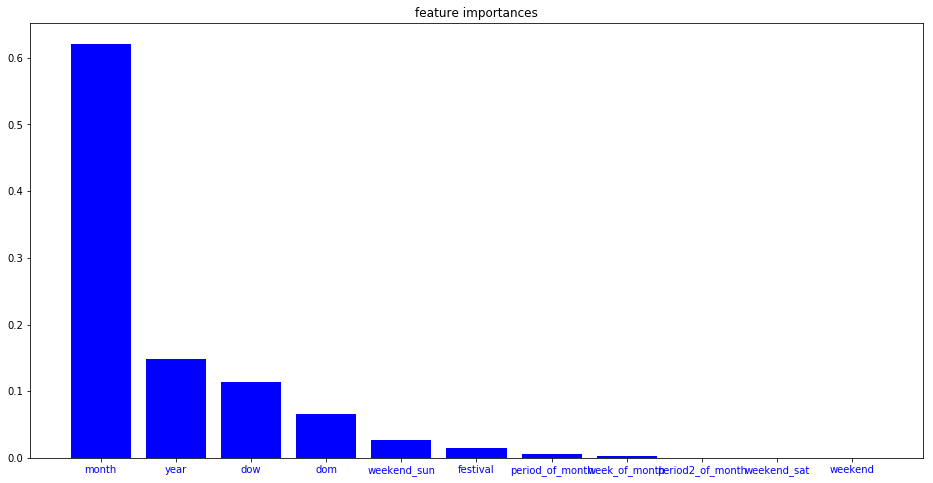

In [150]:
plt.figure(figsize=(16,8))
plt.title("feature importances")
plt.bar(range(len(feature_importances)), feature_importances[indices], color='b')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[indices], color='b')

In [171]:
help(pd.Series.sort_values)

Help on function sort_values in module pandas.core.series:

sort_values(self, axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
    Sort by the values.
    
    Sort a Series in ascending or descending order by some
    criterion.
    
    Parameters
    ----------
    axis : {0 or 'index'}, default 0
        Axis to direct sorting. The value 'index' is accepted for
        compatibility with DataFrame.sort_values.
    ascending : bool, default True
        If True, sort values in ascending order, otherwise descending.
    inplace : bool, default False
        If True, perform operation in-place.
    kind : {'quicksort', 'mergesort' or 'heapsort'}, default 'quicksort'
        Choice of sorting algorithm. See also :func:`numpy.sort` for more
        information. 'mergesort' is the only stable  algorithm.
    na_position : {'first' or 'last'}, default 'last'
        Argument 'first' puts NaNs at the beginning, 'last' puts NaNs at
        the end.
    
    Retur

也可以直接用 pd.Series.plot 来进行简单画图

In [172]:
feature_sort = pd.Series(rf_reg.feature_importances_, index=train_X.columns.values).sort_values(ascending=False)

In [173]:
feature_sort

month               0.620989
year                0.148876
dow                 0.114198
dom                 0.066066
weekend_sun         0.027228
festival            0.015008
period_of_month     0.005359
week_of_month       0.002276
period2_of_month    0.000000
weekend_sat         0.000000
weekend             0.000000
dtype: float64

In [165]:
help(feature_sort.plot)

Help on SeriesPlotMethods in module pandas.plotting._core object:

class SeriesPlotMethods(BasePlotMethods)
 |  Series plotting accessor and method
 |  
 |  Examples
 |  --------
 |  >>> s.plot.line()
 |  >>> s.plot.bar()
 |  >>> s.plot.hist()
 |  
 |  Plotting methods can also be accessed by calling the accessor as a method
 |  with the ``kind`` argument:
 |  ``s.plot(kind='line')`` is equivalent to ``s.plot.line()``
 |  
 |  Method resolution order:
 |      SeriesPlotMethods
 |      BasePlotMethods
 |      pandas.core.base.PandasObject
 |      pandas.core.base.StringMixin
 |      pandas.core.accessor.DirNamesMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __call__(self, kind='line', ax=None, figsize=None, use_index=True, title=None, grid=None, legend=False, style=None, logx=False, logy=False, loglog=False, xticks=None, yticks=None, xlim=None, ylim=None, rot=None, fontsize=None, colormap=None, table=False, yerr=None, xerr=None, label=None, secondary_y=False, **kw

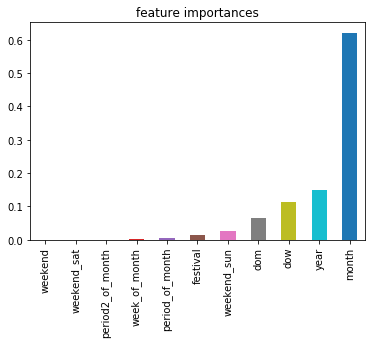

In [168]:
feature_sort.plot(kind='bar',title="feature importances")

#### 结果预测

In [151]:
predictions = rf_reg.predict(test_X)

In [152]:
predictions

array([3883798.81035388, 3800451.81848126, 3922608.22080472,
       3922608.22080472, 3922608.22080472, 3922608.22080472,
       3948793.61358301, 3975820.40553906, 3800451.81848126,
       4040815.20876819, 4040815.20876819, 4040815.20876819,
       4040815.20876819, 4040815.20876819, 3975820.40553906,
       3814392.47522923, 4062535.50984891, 4062535.50984891,
       4062535.50984891, 4062535.50984891, 4087427.89686148,
       3998029.00122174, 3839284.8622418 , 4087427.89686148,
       4087427.89686148, 4087427.89686148, 4087427.89686148,
       4087427.89686148, 3998029.00122174, 3839284.8622418 ,
       4087427.89686148])

In [153]:
test_df.loc[:,'power_consumption'] = predictions

In [154]:
test_df.head()

,record_date,power_consumption
0,2016-10-01,3.883799e+06
1,2016-10-02,3.800452e+06
2,2016-10-03,3.922608e+06
3,2016-10-04,3.922608e+06
4,2016-10-05,3.922608e+06


In [ ]:
test_df.to_csv('tree_model_reg.csv', index=None)